###Project name - To Identify Major Customer Segments in an Online Retail Dataset

Project type - Unsupervised

Contribution - Individual

####Project Summary

The aim of this project is to identify major customer segments from a transnational dataset that encompasses all transactions between 01/12/2010 and 09/12/2011 for a UK-based non-store online retail company. This company primarily sells unique all-occasion gifts, and many of its customers are wholesalers. By leveraging clustering techniques, we can uncover patterns in the customer base, enabling the company to tailor marketing strategies and improve customer satisfaction.

Lets Begin

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




In [4]:
df= pd.read_csv('/content/drive/MyDrive/Data/Online Retail.xlsx - Online Retail.csv')

In [5]:
#top 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [6]:
#last 5 rows
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France


1.DATA INSPECTION

In [7]:
# Display the shape of the dataset
df.shape

(541909, 8)

In [8]:
# Get a concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


2.DATA CLEANING

Checking for missing values

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
#REMOVE DUPLICATE COOLUMNS
#Filter out necessary columns for clustering (e.g., CustomerID, InvoiceNo, Quantity, UnitPrice).
#filling missing values
df.dropna(subset=['CustomerID'], inplace=True)
df.drop_duplicates(inplace=True)


# Create a new column for total purchase
df['TotalPurchase'] = df['Quantity'] * df['UnitPrice']


In [11]:
import datetime as dt

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set reference date
reference_date = dt.datetime(2011, 12, 10)

<ipython-input-11-e6e61c267573>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


3.FEATURE ENGINEERING

Creating Features:
For clustering, we create the Recency, Frequency, and Monetary (RFM) features:

**Recency**: Number of days since the customer's last purchase.

**Frequency**: Total number of transactions by the customer.

**Monetary:** Total amount spent by the customer

In [12]:

# Calculate RFM values
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPurchase': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']


STANDARDIZING THE DATA


To ensure each feature contributes equally to the distance calculations, we standardize the RFM values.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


**K-means Clustering**

K-means clustering is a popular method for partitioning a dataset into distinct, non-overlapping subsets (or clusters).

Applying K-means:
Using the **Elbow method**, we determine the optimal number of clusters by plotting the within-cluster sum of squares (WCSS) against the number of clusters.

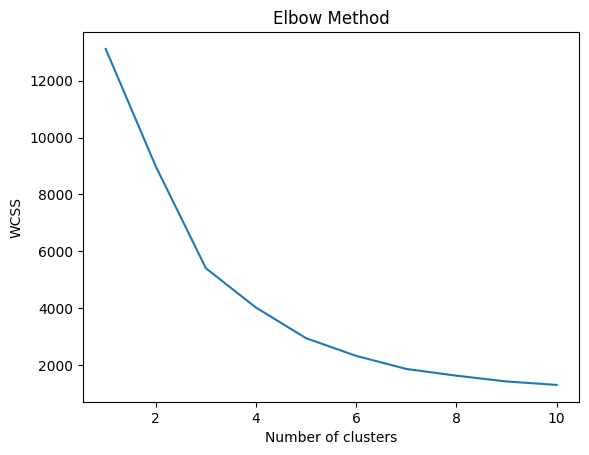

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




From the above graph identified the optimal number of clusters = 3, and fit the K-means algorithm to the data and assign cluster labels.

In [19]:
# Apply K-means with the optimal number of clusters ( 3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

**Hierarchical Clustering**

Apply hierarchical clustering and plot a dendrogram to find the optimal number of clusters.

Now plotting the dendogram to visualize the clusters and decide the optimal cluster

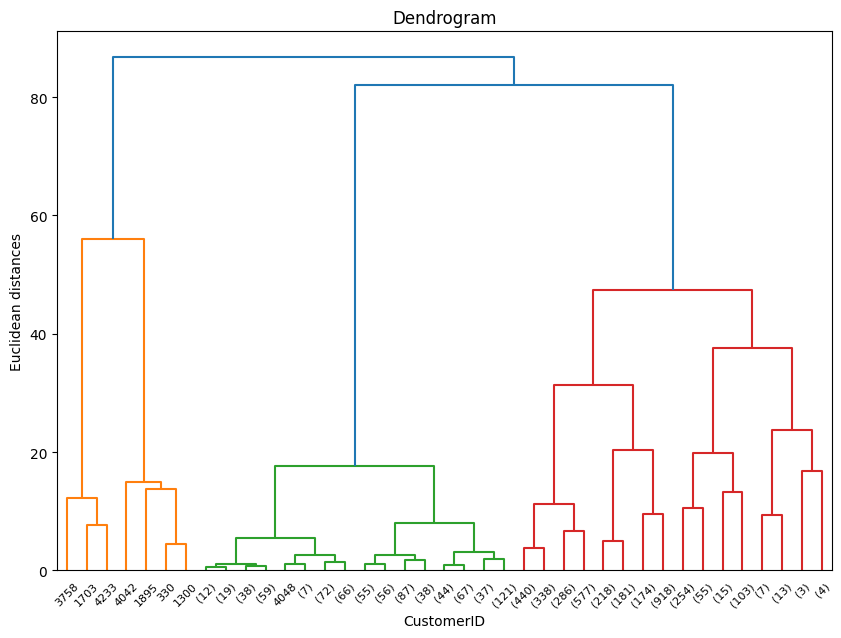

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix
Z = linkage(rfm_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram')
plt.xlabel('CustomerID')
plt.ylabel('Euclidean distances')
plt.show()




**Applying Hierarchical Clustering:**
Based on the dendrogram, we decide the number of clusters = 3 and fit the hierarchical clustering algorithm

In [16]:
# Fit hierarchical clustering with the optimal number of clusters (e.g., 3)
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
rfm['Hierarchical_Cluster'] = hc.fit_predict(rfm_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


**Analyze the Clusters:**

Compare the characteristics of different clusters

Finally, we analyze the clusters formed by both K-means and hierarchical clustering methods to understand the characteristics of each customer segment.

In [20]:
rfm.groupby('KMeans_Cluster').mean()
rfm.groupby('Hierarchical_Cluster').mean()


,Recency,Frequency,Monetary,KMeans_Cluster
Hierarchical_Cluster,,,,
0,2.142857,3737.857143,140157.704286,2.00000
1,51.096486,99.641104,1949.765774,0.91188
2,278.749679,23.268293,392.240603,0.00000


**Interpretation:**

**Cluster 0:**

**Recency** (2 days): Customers in this cluster made their last purchase around 2 days ago. This indicates they are relatively recent customers.

**Frequency** (3737 transactions): These customers have made around 3737 purchases, indicating a very good level of engagement.

**Monetary** (140157): The average amount spent by these customers is 140157 pound, suggesting they are valuable in terms of revenue.

By simply looking at the table the RFM can be known for **cluster 1** and **cluster 2**

**Overall Insights**

**Cluster 0**: Represents highly engaged and highly valuable customers.

**Cluster 1**: Represents customers who are moderately engaged and valuable.

**Cluster 2**:  Represents less engaged and less valuable customers.

###Conclusion

By following these steps, you will have identified major customer segments using both K-means and hierarchical clustering techniques. The RFM model helps in creating meaningful features that reflect customer behavior. K-means clustering provides a clear partition of customers based on their purchasing behavior, while hierarchical clustering offers insights into the nested structure of the data.

**Key Findings**

**K-means Clustering:** The optimal number of clusters is determined using the Elbow method. Each cluster represents a distinct group of customers with similar purchasing behaviors.

**Hierarchical Clustering:** The dendrogram helps visualize the data's structure, enabling the identification of clusters based on hierarchical relationships.

These clustering methods enable the identification of customer segments such as high-value customers, frequent buyers, and recent purchasers. Understanding these segments allows for targeted marketing strategies, personalized communications, and enhanced customer satisfaction, ultimately driving business growth.